$$
\DeclareMathOperator*{\argmin}{argmin}
\DeclareMathOperator*{\E}{\mathbb E}
\newcommand{\R}{\mathbb R}
$$

<!-- SOLUTION CELL -->
<h2 style="color: red">This is the solutions file!</h2>

<span style="color: red">We recommend not looking at this file, which contains the solutions to all the exercises, until after the interactive session is over -- ask for help instead if you're stuck. Use [`ridge.ipynb`](ridge.ipynb) instead.</span>

This is the interactive component of the [ETICS 2022 summer school](https://www.gdr-mascotnum.fr/etics.html) session on "Modern Kernel Methods in Machine Learning" by [Danica Sutherland](https://djsutherland.ml).
Slides are available [here](https://djsutherland.ml/slides/etics-22/) (or in [pdf](https://djsutherland.ml/slides/etics-22.pdf)).

Previous versions of these materials:

- [For DS3 2021](https://github.com/djsutherland/ds3-kernels-21/)
- For [DS3 2019](https://github.com/djsutherland/ds3-kernels/), in discussion with [Bharath Sriperumbudur](http://personal.psu.edu/bks18/)
- Testing material partially based on [a DS3 2018 version](https://github.com/karlnapf/ds3_kernel_testing) by [Heiko Strathmann](http://herrstrathmann.de/) in discussion with [Arthur Gretton](http://www.gatsby.ucl.ac.uk/~gretton/).

We'll cover, in varying levels of detail, the following topics:

- Solving regression problems with kernel ridge regression ([`ridge.ipynb`](ridge.ipynb)):
  - The "standard" approach.
  - Kernel choice, and how it affects the resulting fit.
  - Optionally: learning an appropriate kernel function in a meta-learning setting.
- Two-sample testing with the kernel Maximum Mean Discrepancy (MMD) ([`testing.ipynb`](testing.ipynb)):
  - Estimators for the MMD.
  - Learning an appropriate kernel function.

## Colab

These notebooks are available on Google Colab: [ridge](https://colab.research.google.com/github/djsutherland/etics-kernels-22/blob/built/ridge.ipynb) or [testing](https://colab.research.google.com/github/djsutherland/etics-kernels-22/blob/built/testing.ipynb). You don't have to set anything up yourself and it runs on cloud resources, so this is probably the easiest option. If you want to use the GPU, click Runtime -> Change runtime type -> Hardware accelerator -> GPU.

## Local setup

Otherwise, you can install stuff locally.

Run `check_imports_and_download.py` to see if everything you need is installed (and download some more small datasets if necessary). If that works, you're set; otherwise, read on.


### Files
There are a few Python files and some data files in the repository. By far the easiest thing to do is just put them all in the same directory:

```
git clone --single-branch https://github.com/djsutherland/etics-kernels-22
```

#### Python version
This notebook requires Python 3.6+.

If you've somehow still only used Python 2, it's time to [stop living in the past](https://python3statement.org/), but don't worry! It's almost the same; for the purposes of this notebook, you probably only need to know that you should write `print("hi")` since it's a function call now, and you can write `A @ B` instead of `np.dot(A, B)`.

#### Python packages

The main thing we use is PyTorch and Jupyter. If you already have those set up, you should be fine; just additionally make sure you also have (with `conda install` or `pip install`) `seaborn`, `tqdm`, and `sckit-learn`. We import everything right at the start, so if that runs you shouldn't hit any surprises later on.

If you don't already have a setup you're happy with, we recommend the `conda` package manager - start by installing [miniconda](https://docs.conda.io/en/latest/miniconda.html). Then you can create an environment with everything you need as:

```bash
# replace cpuonly with an appropriate cudatoolkit version if you want GPU support
conda create --name etics-kernels --override-channels -c pytorch -c defaults --strict-channel-priority python=3 notebook ipywidgets numpy scipy scikit-learn matplotlib seaborn tqdm pytorch torchvision cpuonly

conda activate etics-kernels

git clone https://github.com/djsutherland/etics-kernels-22
cd etics-kernels-22
python check_imports_and_download.py
jupyter notebook
```

(If you have an old conda setup, you can use `source activate` instead of `conda activate`, but it's better to [switch to the new style of activation](https://conda.io/projects/conda/en/latest/release-notes.html#recommended-change-to-enable-conda-in-your-shell). This won't matter for this tutorial, but it's general good practice.)

(You can make your life easier when using jupyter notebooks with multiple kernels by installing `nb_conda_kernels`, but as long as you install and run `jupyter` from inside the env it will also be fine.)


## PyTorch

We're going to use PyTorch in this tutorial, even though we're not doing a ton of "deep learning." (The CPU version will be fine, though a GPU might let you get slightly better performance in some of the "advanced" sections.)

If you haven't used PyTorch before, don't worry! The API is unfortunately a little different from NumPy (and TensorFlow), but it's pretty easy to get used to; you can refer to [a cheat sheet vs NumPy](https://github.com/wkentaro/pytorch-for-numpy-users/blob/master/README.md) as well as the docs: [tensor methods](https://pytorch.org/docs/stable/tensors.html) and [the `torch` namespace](https://pytorch.org/docs/stable/torch.html#torch.eq). Feel free to ask if you have trouble figuring something out.


In [2]:
import os
try:
    import google.colab
except ImportError:
    pass
else:
    if not os.path.exists('data/blobs.npz'):
        !git clone https://github.com/djsutherland/etics-kernels-22
        os.chdir('etics-kernels-22')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook')
from IPython.display import display, Markdown, HTML

from tqdm.notebook import tqdm
# from tqdm import tqdm  # if you're in JupyterLab/etc and the above doesn't work well

import functools

import numpy as np
import sklearn
from sklearn import model_selection
import torch
from torch.utils.data import DataLoader
import torchvision

import support
from support import as_tensors, plot_confusion_matrix, LazyKernel, pil_grid

# Download some datasets. We won't need these until later; go ahead and read ahead
# while they're downloading if you want....
torchvision.datasets.MNIST(root='data', download=True)
support.CombinedOmniglot(root='data', download=True)
None

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# This is just checking that tqdm works okay.
# If it doesn't work, then switch to the "from tqdm import tqdm" line above.
import time
print("")
for _ in tqdm(range(100)):
    time.sleep(.01)

  0%|          | 0/100 [00:00<?, ?it/s]

## A note

Please ask me for help if you get stuck! Whether it's with a PyTorch thing, some other code thing, or especially something conceptual – that's what I'm here for. Solutions are also available in [`solutions-ridge.ipynb`](solutions-ridge.ipynb), but you're better off not rushing straight to those; I'm happy to help you try to help you work things out yourself, which is probably better for you. :)

## Ridge regression
Okay, time to get going.

We're going to start with implementing kernel ridge regression. First, here's a toy dataset to test your code on:

In [4]:
# SOLUTION CELL
from sklearn.metrics.pairwise import rbf_kernel

def make_toy(n_pts, dist_seed=17, samp_seed=12):
    drs = np.random.RandomState(seed=dist_seed)
    inducing = drs.uniform(0, 1, size=50)
    w = drs.normal(size=inducing.shape[0])
    gamma = 1 / (2 * .05**2)
    print(f"||f||_H^2: {w @ rbf_kernel(inducing[:, None], gamma=gamma) @ w :.3}")
    
    srs = np.random.RandomState(seed=samp_seed)
    X = srs.uniform(0, 1, size=n_pts)
    ymean = rbf_kernel(X[:, None], inducing[:, None], gamma=gamma) @ w
    y = ymean + srs.normal(scale=.5, size=ymean.shape)
    return X[:, None].astype(np.float32), y.astype(np.float32)

X, y = make_toy(500)
np.savez('data/ridge-toy.npz', X=X, y=y)

||f||_H^2: 32.4


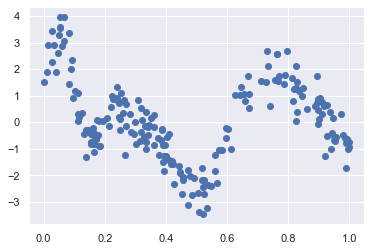

In [5]:
with np.load('data/ridge-toy.npz') as f:
    toy_X = f['X']
    toy_y = f['y']
toy_X_train, toy_X_test, toy_y_train, toy_y_test = model_selection.train_test_split(
    toy_X, toy_y, train_size=200)

fig, ax = plt.subplots()
ax.scatter(toy_X_train[:, 0], toy_y_train)

This data looks like it could be well-modeled by a Gaussian RBF kernel. We'll need a fairly small bandwidth. See the local minimum a little above 0.15 and the local maximum a little past 0.2? The Gaussian kernel still has a fair amount of influnce one bandwidth away, so we want to make the bandwidth a little smaller than that; say 0.05. So, first let's implement the kernel.

<sup>I totally eyeballed that like I said, and definitely didn't just generate the true function in the first place from an RBF function with that bandwidth....</sup>

### Kernels

So, first, let's implement some kernels first. I've put some helper infrastructure in the `LazyKernel` class (in [`support.kernels`](support/kernels.py)) that will be especially useful later; for now, it's just a way to organize computing it. Here's an example of how to use it:

In [6]:
class LinearKernel(LazyKernel):
    def _compute(self, A, B):
        return A @ B.t()

The `_compute` method computes the kernel between two inputs `A` and `B`. (`.t()` is PyTorch for taking a transpose; `@` is the nifty Python 3.6+ syntax for matrix multiplication.) The inputs here are *batches* of data points, for efficient computation: `A` is shape `n_A x dim`, `B` is shape `n_B x dim`. Each row is a data point, of the same dimension, but we might have a different number of data points in `A` and `B`. The result is shape `n_A x n_B`.

The `LazyKernel` base class lets us use this in various ways. First, to find the kernel from one set of points to another:

In [7]:
K = LinearKernel(toy_X_train, toy_X_test)
print(K)
K.XY

<LinearKernel(200, 300)>


tensor([[0.0026, 0.0257, 0.0180,  ..., 0.0241, 0.0168, 0.0159],
        [0.0026, 0.0262, 0.0184,  ..., 0.0246, 0.0171, 0.0162],
        [0.0723, 0.7270, 0.5100,  ..., 0.6822, 0.4747, 0.4500],
        ...,
        [0.0064, 0.0643, 0.0451,  ..., 0.0603, 0.0420, 0.0398],
        [0.0010, 0.0102, 0.0072,  ..., 0.0096, 0.0067, 0.0063],
        [0.0807, 0.8110, 0.5689,  ..., 0.7611, 0.5295, 0.5020]])

You can also get the X-to-X (`XX`) and Y-to-Y (`YY`) kernel matrices from the same object (which are the result of `_compute(X, X)` and `_compute(Y, Y)`). These aren't computed until you need them, but then they're cached after you use them the first time; this is why it's a `LazyKernel`.

In [8]:
K.XX

tensor([[6.9101e-04, 7.0363e-04, 1.9529e-02,  ..., 1.7262e-03, 2.7439e-04,
         2.1786e-02],
        [7.0363e-04, 7.1647e-04, 1.9885e-02,  ..., 1.7577e-03, 2.7941e-04,
         2.2184e-02],
        [1.9529e-02, 1.9885e-02, 5.5191e-01,  ..., 4.8785e-02, 7.7548e-03,
         6.1569e-01],
        ...,
        [1.7262e-03, 1.7577e-03, 4.8785e-02,  ..., 4.3122e-03, 6.8546e-04,
         5.4423e-02],
        [2.7439e-04, 2.7941e-04, 7.7548e-03,  ..., 6.8546e-04, 1.0896e-04,
         8.6510e-03],
        [2.1786e-02, 2.2184e-02, 6.1569e-01,  ..., 5.4423e-02, 8.6510e-03,
         6.8685e-01]])

If you only want the kernel matrix for a dataset to itself, you can just not pass the second argument. Then K.XY won't exist.

In [9]:
LinearKernel(toy_X_train).XX

tensor([[6.9101e-04, 7.0363e-04, 1.9529e-02,  ..., 1.7262e-03, 2.7439e-04,
         2.1786e-02],
        [7.0363e-04, 7.1647e-04, 1.9885e-02,  ..., 1.7577e-03, 2.7941e-04,
         2.2184e-02],
        [1.9529e-02, 1.9885e-02, 5.5191e-01,  ..., 4.8785e-02, 7.7548e-03,
         6.1569e-01],
        ...,
        [1.7262e-03, 1.7577e-03, 4.8785e-02,  ..., 4.3122e-03, 6.8546e-04,
         5.4423e-02],
        [2.7439e-04, 2.7941e-04, 7.7548e-03,  ..., 6.8546e-04, 1.0896e-04,
         8.6510e-03],
        [2.1786e-02, 2.2184e-02, 6.1569e-01,  ..., 5.4423e-02, 8.6510e-03,
         6.8685e-01]])

You can also pass three arguments; then there'll be `XZ`, etc. You can also access them with e.g. `K[0, 2]`.

Here's an example of a slightly more complex kernel class, with some parameters:

In [10]:
class PolynomialKernel(LazyKernel):
    def __init__(self, X, *rest, degree=3, gamma=None, coef0=1):
        super().__init__(X, *rest)
        self.degree = degree
        self.gamma = 1 / X.shape[1] if gamma is None else gamma
        self.coef0 = coef0

    def _compute(self, A, B):
        XY = A @ B.t()
        return (self.gamma * XY + self.coef0) ** self.degree

Remember that the Gaussian RBF kernel is
$$k(X_i, X_j) = \exp\left( -\frac{1}{2 \sigma^2} \lVert X_i - X_j \rVert^2 \right).$$

**Exercise:** Implement that here.

It might be helpful to recall that
$$\lVert X_i - X_j \rVert^2 = \lVert X_i \rVert^2 + \lVert X_j \rVert^2 - 2 X_i^T X_j;$$
you should probably convert that into a matrix form to implement it.

Alternatively, [`torch.pdist`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.pdist) computes these distances, but it only gives you the upper triangle of the matrix so you'll have to turn it into a full symmetric matrix yourself.

In [11]:
class RBFKernel(LazyKernel):
    def __init__(self, *parts, sigma=1):
        super().__init__(*parts)
        self.sigma = sigma
        # This next line doesn't really matter here, but helps a bit in the mmd stuff:
        self.const_diagonal = 1  # Declares that k(x, x) = 1 for any x
    
    def _compute(self, A, B):  # TODO: implement _compute
        A_sqnorms = torch.einsum("ij,ij->i", A, A)                       # SOLUTION
        B_sqnorms = torch.einsum("ij,ij->i", B, B)                       # SOLUTION
        D2 = A_sqnorms[:, None] + B_sqnorms[None, :] - 2 * (A @ B.t())   # SOLUTION
        return torch.exp(D2 / (-2 * self.sigma ** 2))                    # SOLUTION

You can check your implementation against scikit-learn's implementation (but it doesn't work in PyTorch, so don't just use it directly):

In [12]:
sigma = np.random.lognormal()
K = RBFKernel(toy_X_train, toy_X_test, sigma=sigma)

from sklearn.metrics.pairwise import rbf_kernel
gamma = 1 / (2 * sigma**2)  # sklearn uses this parameterization
assert np.allclose(K.XX.numpy(), rbf_kernel(toy_X_train, gamma=gamma))
assert np.allclose(K.XY.numpy(), rbf_kernel(toy_X_train, toy_X_test, gamma=gamma))
assert np.allclose(K.YY.numpy(), rbf_kernel(toy_X_test, gamma=gamma))
print("Passed the assertions, seems good!")

del rbf_kernel

Passed the assertions, seems good!


### Implementing ridge regression

Okay, now we can compute all kinds of kernels; let's actually use them for something. First, let's implement kernel ridge regression:
$$
  \min_{f \in \mathcal{H}} \frac{1}{n} \sum_{i=1}^n \lVert f(X_i) - y_i \rVert^2 + \lambda \lVert f \rVert_{\mathcal{H}}^2 
.$$
As we saw in the lecture, the representer theorem tells us that $f(x) = \sum_{i=1}^n \alpha_i k(X_i, x)$.
We *could* then solve this with gradient descent or some other iterative optimizer; indeed, sometimes this (usually with conjugate gradient) is the most effective option.
But for today's purposes, we're going to prefer the analytical solution:
some calculus gives us
$$\alpha = (K + n \lambda I)^{-1} y, \tag{*}$$
where $K_{ij} = k(X_i, X_j)$.

(If you're familiar with Gaussian processes but not ridge regression, the function $f$ is exactly the posterior mean of a Gaussian process. If you're not familiar with GPs, never mind.)

There's also one more wrinkle: we're going to need to compute ridge regression for multiple outputs $y$ at once with the same $X$s. This just means solving the linear system for more than one $y$ at once; most software, including PyTorch, supports this built-in.

To implement $\textrm{(*)}$, there are (at least) two approaches.

- [`torch.linalg.solve`](https://pytorch.org/docs/stable/torch.html#torch.solve) is a general-purpose matrix solver, which uses an [LU decomposition](https://en.wikipedia.org/wiki/LU_decomposition). This doesn't exploit the special structure of kernel matrices (namely that they're [positive-definite](https://en.wikipedia.org/wiki/Definiteness_of_a_matrix)).

- You could also use a [Cholesky factorization](https://en.wikipedia.org/wiki/Cholesky_factorization), which is the standard approach for positive-definite matrices, and will be somewhat faster. You could implement this with [`torch.linalg.cholesky`](https://pytorch.org/docs/stable/torch.html#torch.cholesky) and then either [`torch.cholesky_solve`](https://pytorch.org/docs/stable/torch.html#torch.cholesky_solve) or [`torch.triangular_solve`](https://pytorch.org/docs/stable/torch.html#torch.triangular_solve) directly; Cholesky gives us $L$ such that $K + n \lambda I = L L^T$, so you'll want $\alpha = (L L^T)^{-1} y = L^{-T} (L^{-1} y)$. (Make sure to pass `upper=False` to `triangular_solve`.)

In [13]:
class KernelRidgeRegression:
    def __init__(
        self,
        reg_wt=1,
        solver='cholesky',  # SOLUTION
    ):
        """
        reg_wt: The regularization weight lambda.
        """
        self.reg_wt = reg_wt
        self.solver = solver  # SOLUTION
    
    def fit(self, K_XX, y):
        """
        Fit the ridge regression:
        
          K_XX: The training kernel matrix, of shape [n_train, n_train].
          y: The training labels, of shape [n_train] or [n_train, n_labels].        
        """
        K_XX, y = as_tensors(K_XX, y)
        
        assert len(K_XX.shape) == 2
        self.n_train_ = n_train = K_XX.shape[0]
        
        if len(y.shape) == 1:
            self.n_labels_ = None
            y = y[:, None]
        else:
            assert len(y.shape) == 2
            self.n_labels_ = y.shape[1]

        assert K_XX.shape[1] == y.shape[0] == self.n_train_
        
        # TODO: find the solution, and save it in eg self.alpha_
        reg = self.reg_wt * n_train * torch.eye(n_train, device=K_XX.device)  # SOLUTION
        to_inv = K_XX + reg                                                   # SOLUTION
        if self.solver == 'lu':                                               # SOLUTION
            # the LU-based solution                                           # SOLUTION
            self.alpha_ = torch.linalg.solve(to_inv, y)                       # SOLUTION
        elif self.solver == 'cholesky':                                       # SOLUTION
            # the cholesky solution (default)                                 # SOLUTION
            L = torch.linalg.cholesky(to_inv)                                 # SOLUTION
            inner = torch.triangular_solve(y, L, upper=False).solution        # SOLUTION
            self.alpha_ = torch.triangular_solve(                             # SOLUTION
                inner, L, upper=False, transpose=True).solution               # SOLUTION
        else:                                                                 # SOLUTION
            raise ValueError(f"unknown solver {self.solver!r}")               # SOLUTION
    
    def predict(self, K_test):
        """
        Predict the labels of a test set.
        
          K_test: The train-to-test kernel matrix, shape [n_train, n_test].
        
        Return: the vector of test predictions, shape [n_test].
        """
        K_test = torch.as_tensor(K_test)
        assert len(K_test.shape) == 2
        assert K_test.shape[0] == self.n_train_
        
        # TODO: set preds to shape [n_test, n_labels]
        preds = K_test.t() @ self.alpha_     # SOLUTION
        
        # return a vector if we were fit with a vector, matrix otherwise
        return preds.squeeze(1) if self.n_labels_ is None else preds
    
    def mses(self, K_test, y_test, return_preds=False):
        """
        Computes the mean squared error of each output for a test set.
        
          K_test: The train-to-test kernel matrix, shape [n_train, n_test].
          y_test: The test labels, shape [n_train] or [n_train, n_labels]
                  (agreeing with what was passed to fit()).
                  
        Returns a vector if y_test is 2d, or a scalar if not.
        """
        preds = self.predict(K_test)
        y_test = torch.as_tensor(y_test)
        assert preds.shape == y_test.shape
        errs = ((preds - y_test) ** 2).mean(0)
        return (errs, preds) if return_preds else errs
    
    def mse(self, K_test, y_test, return_preds=False):
        """
        Computes the mean squared error across outputs for a test set.
        
          K_test: The train-to-test kernel matrix, shape [n_train, n_test].
          y_test: The test labels, shape [n_train] or [n_train, n_labels]
                  (agreeing with what was passed to fit()).
                  
        Returns a scalar.
        """
        errs, preds = self.mses(K_test, y_test, return_preds=True)
        err = errs.mean()
        return (err, preds) if return_preds else err

Does it work?

In [14]:
def evaluate(krr, kernel_cls=None, plot=True,
             X_train=None, y_train=None, X_test=None, y_test=None):
    if X_train is None:
        X_train = toy_X_train
    if y_train is None:
        y_train = toy_y_train
    if X_test is None:
        X_test = toy_X_test
    if y_test is None:
        y_test = toy_y_test
    
    plot_xs = np.linspace(0, 1, num=500)[:, None]
    if kernel_cls is None:
        kernel_cls = functools.partial(RBFKernel, sigma=0.05)
    K = kernel_cls(X_train, X_test, plot_xs)

    krr.fit(K.XX, y_train)
    train_mse = krr.mse(K.XX, y_train).item()
    test_mse = krr.mse(K.XY, y_test).item()
    
    if plot:
        fig, ax = plt.subplots()
        ax.scatter(X_train[:, 0], y_train)
        ax.plot(plot_xs, krr.predict(K.XZ).numpy(), lw=4, color='r')
        ax.set_title(f"Train MSE: {train_mse:.2} / Test MSE: {test_mse:.2}")
    else:
        return train_mse, test_mse

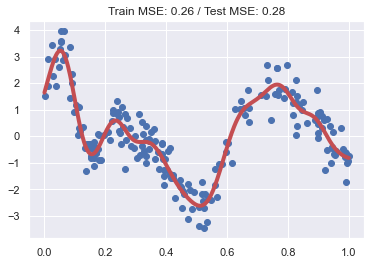

In [15]:
evaluate(KernelRidgeRegression(reg_wt=.001))
plt.savefig('figs/toy-krr-eval.png')  # SOLUTION

Here's what my solution looks like:
![hi](figs/toy-krr-eval.png)

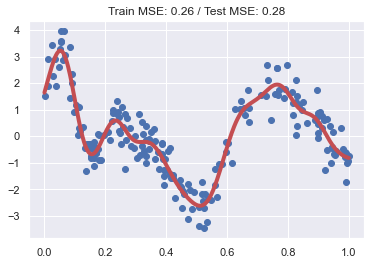

In [16]:
# SOLUTION CELL
# Check that the LU solve also works; should be almost identical.
evaluate(KernelRidgeRegression(reg_wt=.001, solver='lu'))

### Choice of $\lambda$
For this problem, we want a pretty small $\lambda$, just enough to make it work, since the amount of inherent noise in the problem is fairly small. To check this, let's just try a bunch of different $\lambda$s.

(Note that the Cholesky solution is likely to crash with small $\lambda$ before the `torch.solve` solution would, because – especially in the `float32` computation we're doing here – $K + n \lambda I$ will appear singular. My results image below used the `torch.solve` version.)

**Exercise**: What do you think will happen visually when you change $\lambda$? Try a few different numbers for `reg_wt`, including increasing it really high, and see if it matches your intuition.

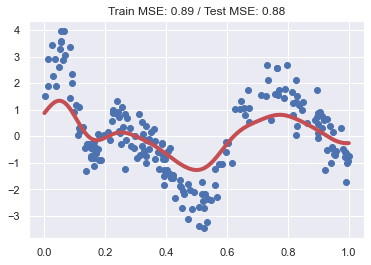

In [17]:
evaluate(KernelRidgeRegression(reg_wt=.1))

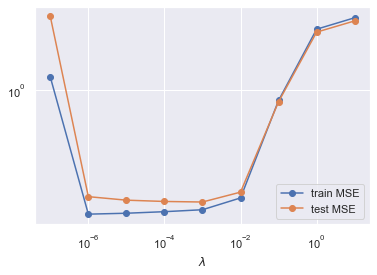

In [18]:
lams = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
train_mses = []
test_mses = []
for lam in lams:
    krr = KernelRidgeRegression(reg_wt=lam)
    krr.solver = 'lu'    # SOLUTION
    try:
        train, test = evaluate(krr, plot=False)
    except RuntimeError as e:
        print(f"{lam}: {e}")
        train = test = np.nan
    train_mses.append(train)
    test_mses.append(test)
    
fig, ax = plt.subplots()
ax.plot(lams, train_mses, marker='o', label='train MSE')
ax.plot(lams, test_mses, marker='o', label='test MSE')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda$')
fig.savefig('figs/toy-krr-lambda.png')  # SOLUTION

My results, for reference, look like:
![](figs/toy-krr-lambda.png)

My Cholesky solution failed for $\lambda = 10^{-7}$, so your plot might cut off the first points, or behave a little differently. In my plot at least, we can actually tell that the behavior for the smallest values of $\lambda$ is numerical error, not overfitting: overfitting would increase the test error as we decrease $\lambda$, but it shouldn't increase the training error. (We can see a mild amount of overfitting happening at $\lambda = 10^{-6}$ here: train error is a little lower, but test error has ticked up a tiny bit.)

### Choosing the kernel

We can also see whether my guess at $\sigma$ was really right.

**Exercise:** First, what happens when you change $\sigma$? Try some numbers, including much larger and much smaller ones, and see if it looks like what you expect to happen. See how this interacts with setting $\lambda$ as well.

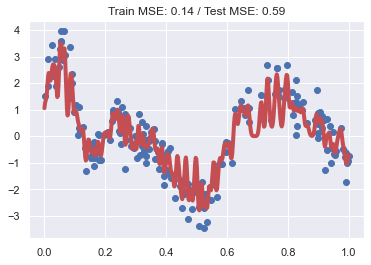

In [19]:
evaluate(KernelRidgeRegression(reg_wt=.001),
         kernel_cls=functools.partial(RBFKernel, sigma=.005))

**Exercise:** What happens if you use `LinearKernel`? `PolynomialKernel`, with different `degree`?

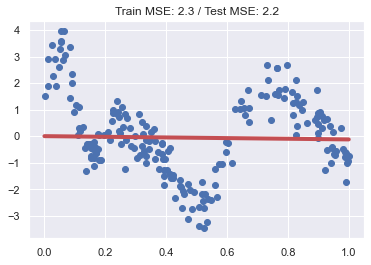

In [20]:
evaluate(KernelRidgeRegression(reg_wt=.001),
         kernel_cls=functools.partial(LinearKernel))

Going back to `RBFKernel`, let's do a joint search over $\lambda$ and $\sigma$, since they'll interact with one another:

(No need to worry about the particulars of this code: it's just calling `KernelRidgeRegression` for a grid of `lams` and `sigs`, then plotting the results. Also, if you get some matplotlib warnings, don't worry about it; they're just slightly fiddly to work around.)

/var/folders/yt/b4hm6yts20x78pfnpt46hvbm0000gn/T/ipykernel_30623/4061728094.py:31: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im)
/var/folders/yt/b4hm6yts20x78pfnpt46hvbm0000gn/T/ipykernel_30623/4061728094.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels([''] + [f'{sig}' for sig in sigs])
/var/folders/yt/b4hm6yts20x78pfnpt46hvbm0000gn/T/ipykernel_30623/4061728094.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels([''] + [f'{lam}' for lam in lams])


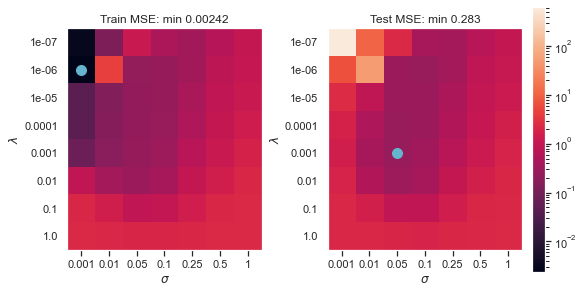

In [21]:
lams = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]
sigs = [.001, .01, .05, .1, .25, .5, 1]
mses = np.full((len(lams), len(sigs), 2), np.nan)

for lam_i, lam in enumerate(lams):
    for sig_i, sig in enumerate(sigs):
        krr = KernelRidgeRegression(reg_wt=lam)
        krr.solver = 'lu'  # SOLUTION
        try:
            mses[lam_i, sig_i, :] = evaluate(
                krr, functools.partial(RBFKernel, sigma=sig), plot=False)
        except RuntimeError as e:
            print(f"{lam} {sig}: {e}")

fig, axes = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)

norm = mpl.colors.LogNorm(vmin=np.nanmin(mses), vmax=np.nanmax(mses))

ax1, ax2 = axes
ax1.grid(False)
ax1.matshow(mses[:, :, 0], norm=norm)
best1, best2 = np.unravel_index(np.argmin(mses[:, :, 0]), mses.shape[:2])
ax1.scatter([best2], [best1], marker='o', color='c', s=100)
ax1.set_title(f"Train MSE: min {mses[best1, best2, 0]:.3}")

ax2.grid(False)
im = ax2.matshow(mses[:, :, 1], norm=norm)
best1, best2 = np.unravel_index(np.argmin(mses[:, :, 1]), mses.shape[:2])
ax2.scatter([best2], [best1], marker='o', color='c', s=100)
ax2.set_title(f"Test MSE: min {mses[best1, best2, 1]:.3}")
fig.colorbar(im)

for ax in axes:
    ax.grid(False)
    
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_ticklabels([''] + [f'{sig}' for sig in sigs])
    ax.set_xlabel(r'$\sigma$')
    
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.yaxis.set_ticklabels([''] + [f'{lam}' for lam in lams])
    ax.set_ylabel(r'$\lambda$')
    
fig.savefig('figs/toy-krr-sig-lambda.png');  # SOLUTION
# If you get a RuntimeWarning due to nans, don't worry about it...

For reference, my result looks like
![](figs/toy-krr-sig-lambda.png)
Smaller $\sigma$ can get lower training error, but the best test error is definitely with $\sigma = 0.05$.

### Shifting `y`

What do you think will happen if we fit with `y` replaced by `y + 100`?

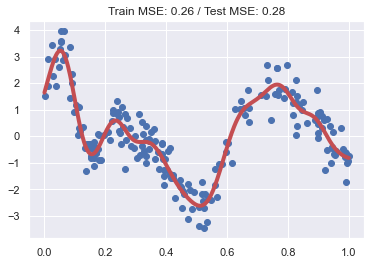

In [22]:
# normal fit, for comparison
evaluate(KernelRidgeRegression(reg_wt=.001))

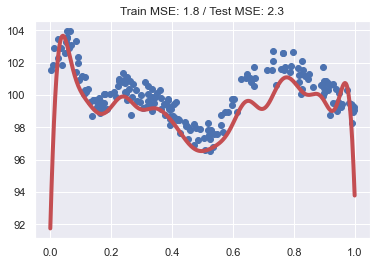

In [23]:
# fit with labels shifted upwards by 100
evaluate(KernelRidgeRegression(reg_wt=.001),
         y_train=toy_y_train + 100, y_test=toy_y_test + 100)

Some

blank

space

so

you

run

it

and

think

about

it

before

reading

on

...

<br>
<span style="font-size: 3em">🤔</span>

<br>
<span style="font-size: 3em">🤔</span>

<br>
<span style="font-size: 3em">🤔</span>

Remember that in traditional linear regression, you fit $y = w \cdot x + b$. Here, we're using $y = w \cdot \varphi(x)$; no $+ b$. Unlike in traditional linear regression, the kernel can more-or-less account for it, but the weird thing at the end – and the overall downward trend – could be fixed by adding an offset.

The easiest way to do that is to add an additional dimension to $\varphi(x)$ that's just a constant $1$, so that the corresponding element of $w$ can be $b$. Since $k(x, y) = \varphi(x) \cdot \varphi(y)$, this means that we just add 1 to the kernel.

In [24]:
class RBFKernelPlusOne(RBFKernel):
    def _compute(self, *args):
        return super()._compute(*args) + 1

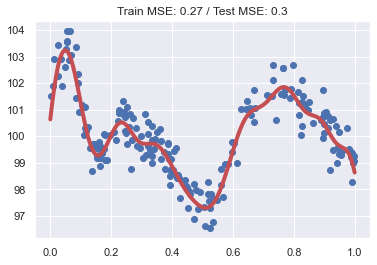

In [25]:
evaluate(KernelRidgeRegression(reg_wt=.001),
         kernel_cls=functools.partial(RBFKernelPlusOne, sigma=.05),
         y_train=toy_y_train + 100, y_test=toy_y_test + 100)

Much better!

One thing to note: traditional ridge regression regularizes with $\lambda \lVert w \rVert^2$, and leaves $b$ unregularized. This has nice properties like making the fit shift _exactly_ along with an offset $y$. By adding 1 to the kernel, though, ours will _slightly_ change with offsets, because we're also effectively regularizing with $\lambda b^2$.

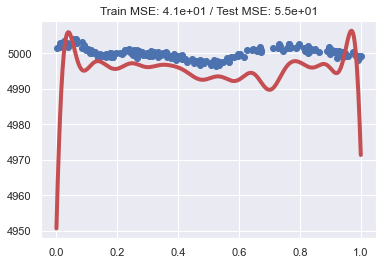

In [26]:
evaluate(KernelRidgeRegression(reg_wt=.001),
         kernel_cls=functools.partial(RBFKernelPlusOne, sigma=.05),
         y_train=toy_y_train + 5000, y_test=toy_y_test + 5000)

There are a few ways to resolve this:

1. Actually add an unregularized offset into the model and work it out properly. Unfortunately, this actually breaks some of the RKHS stuff; if you're so inclined, it's an interesting exercise to work out what happens here.
2. Mitigate the scaling by adding a large constant, instead of 1; if you add $c$, then the regularization on $b$ is effectively $\lambda {b^2}/{c^2}$.
3. Just subtract the mean of `y_train` before passing it into the model, then add it on to predictions later.

People normally do option 3 in practice.

### A harder problem

Okay, that problem was too easy. Let's do something slighty more interesting.

Not _too_ interesting, though; we'll start with the MNIST dataset of handwritten images, with the goal of identifying which digit an image is. (We're building up!)

But this is a classification dataset, and we're doing ridge regression right now, you say!

That's true. You'd probably do better to use an actual classification loss. But we're going to just do regression to "one-hot" labels, that is the label for an image of a handwritten 0 will be
$$
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
.$$
We're going to use our multi-output support for RidgeRegression that we implemented before to train 10 different regression models: one that predicts the degree of zero-ness of an image, one for the one-ness, etc.

(This is sometimes called the [Brier score](https://en.wikipedia.org/wiki/Brier_score#Original_definition_by_Brier), and it is a [proper scoring rule](https://en.wikipedia.org/wiki/Scoring_rule#ProperScoringRules). So, yes, you could get better performance from other losses, but this one is at least well-posed.)

In [27]:
# some utilities for pytorch datasets

def read(ds, batch_size=None, **kwargs):
    if batch_size is None:
        batch_size = len(ds)
    return next(iter(DataLoader(ds, batch_size=batch_size, **kwargs)))

def random_subset(ds, n):
    return torch.utils.data.random_split(ds, [n, len(ds) - n])[0]

MNIST = functools.partial(
    torchvision.datasets.MNIST,
    root='data',
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        lambda t: t.reshape(784),
    ]),
    target_transform=lambda y:
        torch.nn.functional.one_hot(torch.as_tensor(y), num_classes=10).float()
)

mnist_train = MNIST(train=True)
mnist_test = MNIST(train=False)

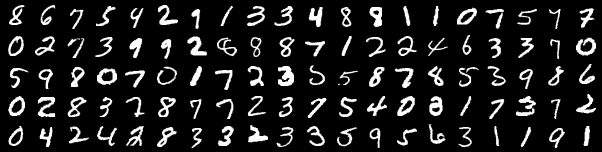

In [28]:
# Just look at some data points
X, y = read(mnist_train, batch_size=100, shuffle=True)
pil_grid(X.reshape(-1, 1, 28, 28), nrow=20)

MNIST has 60,000 images. Even constructing a, say, 50,000 $\times$ 50,000 matrix is maybe too much, so for now, let's try training on a random subset first, though, to (a) check that our multi-output implementation works, and (b) set a baseline to compare to for the other methods.

In [29]:
# get a subset of the data
train_X, train_y = read(mnist_train, 5_000, shuffle=True)
test_X, test_y = read(mnist_test, 5_000, shuffle=True)

In [30]:
def clf_eval(truth, preds, label_names=None):
    if label_names is None:
        label_names = np.arange(truth.shape[1]).astype(str)
        
    # want integers instead of one-hot
    truth = truth.argmax(1)
    preds = preds.argmax(1)
    
    ax = plot_confusion_matrix(truth, preds, label_names, rotation=0, figsize=(7, 6))
    fig = ax.figure
    display(fig)
    plt.close(fig)
    
    report = sklearn.metrics.classification_report(
        truth, preds, target_names=label_names, zero_division=0)
    display(HTML(f'<pre>{report}</pre>'))

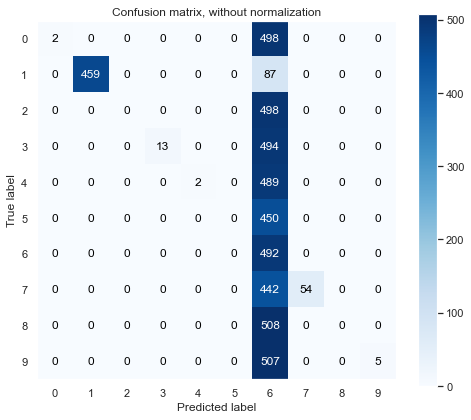

In [31]:
K = RBFKernelPlusOne(train_X, test_X)

krr = KernelRidgeRegression(reg_wt=1e-5)
krr.fit(K.XX, train_y)
test_preds = krr.predict(K.XY)

clf_eval(test_y, test_preds)

Yeah....that wasn't great. We forgot to set the kernel bandwidth.

A usual heuristic to start with is the median distance between data points.

**Exercise:** compute the median distance between training data points. You can either compute this yourself, or use predefined functions, whichever you'd prefer. If it's too slow to compute, you can subsample the data points.

In [32]:
# TODO: find med_sigma
med_sigma = torch.median(torch.pdist(train_X)).item() # SOLUTION
med_sigma

10.272007942199707

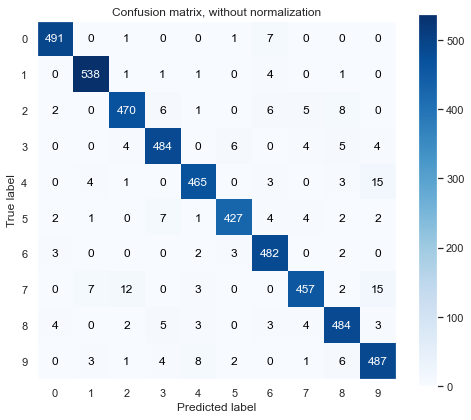

In [33]:
K = RBFKernelPlusOne(train_X, test_X, sigma=med_sigma)

krr = KernelRidgeRegression(reg_wt=1e-5)
krr.fit(K.XX, train_y)
test_preds = krr.predict(K.XY)

clf_eval(test_y, test_preds)

Much better! I got 96% accuracy, which is pretty reasonable. (You can do better with a convnet, of course, but not bad for such a simple model.)

Note that these predictions aren't actually valid probabilities, which is slightly annoying: as you can see, we're getting numbers below 0 and above 1. Whether this is important depends on your use case.

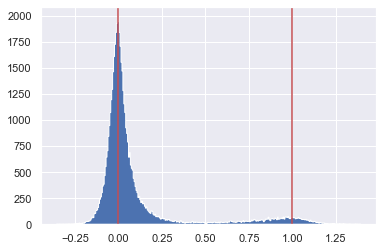

In [34]:
plt.hist(test_preds.numpy().ravel(), bins='auto', histtype='stepfilled');
plt.axvline(0, color='r')
plt.axvline(1, color='r')

But, maybe we can do better by picking a different $\sigma$ than the median? And what about the arbitrary choice of regularization weight?

We could do a grid search like before, but let's do something more fun: gradient descent!

We want to find the derivative of the validation error with respect to $\sigma$ and $\lambda$. That is,
$$
\nabla_{\sigma\lambda} \frac{1}{n^\text{val}} \sum_{i=1}^{n^\text{val}} \lVert
    \hat{y}_{X_\text{train},\sigma,\lambda}(X_i^\text{val}) - y_i^\text{val}
\rVert^2
,$$
where $\hat{y}_{X_\text{train},\sigma,\lambda}$ is the predictor trained with $X_\text{train}$ using kernel bandwidth $\sigma$ and regularization $\lambda$.

(Although $\hat y$ fundamentally uses the square loss, we could conceivably use another "outer" loss. But since $\hat y$ isn't a distribution, we can't use cross-entropy or similar losses, so square loss is a reasonable choice. If we really wanted, we could e.g. learn an affine transformation of these outputs and then apply a softmax to them to get valid probabilities in the end.)

Because we have a PyTorch expression for the whole process of $\hat{y}$, we can just take derivatives. We'll paramaterize with $\log \lambda$ and $\log \sigma$, though, to avoid invalid values (and because it's probably a better domain for each anyway).

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, '$\\sigma$')

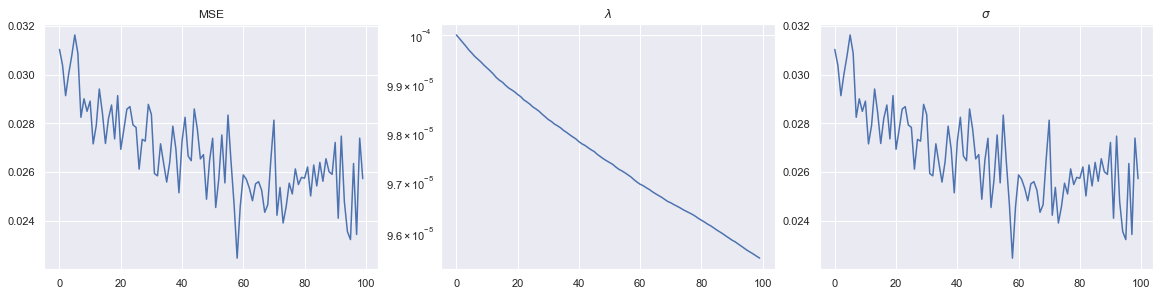

In [35]:
device = 'cpu'
# You can use a GPU here if you want, but you have to have been careful about
# managing the device of tensors in your implementation or it might crash.
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

log_lam = torch.tensor(np.log(1e-4), requires_grad=True, device=device)
log_sig = torch.tensor(np.log(med_sigma), requires_grad=True, device=device)
opt = torch.optim.SGD([log_lam, log_sig], lr=1)  # feel free to fiddle with

trace = []

n_steps = 100 # Feel free to increase...
with tqdm(range(n_steps)) as bar:
    for i in bar:
        opt.zero_grad()  # reset gradient state before computing things
        
        lam = torch.exp(log_lam)
        sig = torch.exp(log_sig)

        # Fitting on the full training set is a little slow,
        # so let's subsample.
        # Also, since we're optimizing parameters based on fit performance,
        # we should evaluate on points from the *training set*.
        
        batches = iter(DataLoader(mnist_train, batch_size=500, shuffle=True))
        sub_train_X, sub_train_y = [x.to(device) for x in next(batches)]
        sub_val_X, sub_val_y = [x.to(device) for x in next(batches)]
        
        # compute the loss on the validation set
        krr = KernelRidgeRegression(reg_wt=lam)
        K = RBFKernelPlusOne(sub_train_X, sub_val_X, sigma=sig)
        krr.fit(K.XX, sub_train_y)
        loss = krr.mse(K.XY, sub_val_y)

        loss.backward()  # compute the gradients
        opt.step()       # update lam / sig following the gradients
        lam_val = lam.cpu().item()
        sig_val = sig.cpu().item()
        loss_val = loss.cpu().item()
        trace.append((i, lam_val, sig_val, loss_val))
        bar.set_postfix(lam=f"{lam_val:.4}", sig=f"{sig_val:.4}", loss=f"{loss_val:.4}")

fig, (a1, a2, a3) = plt.subplots(ncols=3, figsize=(16, 4), constrained_layout=True)
inds, lams, sigs, losses = np.asarray(trace).T

a1.plot(inds, losses)
a1.set_title("MSE")

a2.plot(inds, lams)
a2.set_title(r"$\lambda$")
a2.set_yscale('log')

a3.plot(inds, losses)
a3.set_title(r"$\sigma$")

Looks like it actually does better with a slightly smaller bandwidth (and a smaller $\lambda$).

One caveat to this is that the optimal parameters will generally depend on $n$; here we're finding the best parameters for a fit on 500 training points, but you might want smaller $\lambda$ and $\sigma$ as $n$ grows.

Since the loss landscape is surely nonconvex, it might be better to combine grid search and local gradient descent, starting from various locations. We could of course try other optimizers too.

**Exercise:** Did this optimization help the MSE that it's optimizing on the test set (`mnist_test`) versus our heuristic guess before? What about the classification accuracy?

<span style="color: blue">At this point, you've finished the baseline of this chunk of the tutorial.<sup>(Don't you feel smarter?)</sup></span>
    
<span style="color: blue">There are now some more-or-less independent sections remaining for the ridge regression component; feel free to do whichever you feel like of them, in any order.</span>

## Leave-one-out

Leave-one-out cross-validation is where you fit on $n-1$ data points and test on the remaining one, loop over the dataset so each point is left out one time, and use that as an estimate of your generalization error. Compared to using a single validation set like above, it lets you get good hyperparameters for $n-1$ data points rather than, say, $0.8n$ data points, and it also lets every point serve as a validation point – but it's averaging over $n$ very dependent estimates (they're all fit on _almost_ the same dataset), so it's not actually always better than doing, say, 5-fold CV.

For ridge regression, the leave-one-out cross-validation error is actually possible to find in closed form, by doing the regression on all $n$ data points then doing a rank-one update to remove a single data point at a time. It works out to (see e.g. Theorem 3.2 [here](https://openreview.net/pdf?id=7grkzyj89A_), though the result is classical)
$$
L_\mathit{loo} = \frac1n \sum_{i=1}^n \left( \frac{y_i - \hat f_{\!\lambda}(X_i)}{1 - A_{ii}} \right)^2
$$
where $\hat f_{\!\lambda}$ is the ridge regression estimate on the full data,
and the matrix $A$ is given by $K (K + n \lambda I)^{-1}$.
If you want,
implement this loss, verify that it agrees with manually doing leave-one-out regression,
and change to use that instead of the single train-val split below.

## Further exploration of the kernel for ridge regression

Here are some more open-ended questions you might want to explore at this point (but also consider going on to the remaining sections of the tutorial.

**Note:** MNIST might be too easy to really look into these (since we're already at 96% accuracy with the most basic thing). You could try `torchvision.datasets.FashionMNIST` or `torchvision.datasets.CIFAR10`. (Pass `root='data', download=True` to get them if necessary.)

**Exercise:** Try other kernels than the Gaussian RBF on this data. Some that might be interesting:
\begin{align}
\exp\left( -\frac12 \left(\frac{\lVert x - y \rVert}{\ell}\right)^\beta \right)
&\qquad\text{ for $0 < \beta \le 2$ ($\beta = 2$ is Gaussian, $\beta = 1$ is Laplacian)}
\\
\lVert x - z_0 \rVert + \lVert y - z_0 \rVert - \lVert x - y \rVert
&\qquad\text{ for any $z_0$ ("distance kernel")}
\\
\frac{1}{\sqrt{\lVert x - y \rVert^2 + c}}
&\qquad\text{ (inverse multiquadric)}
\\
\left( 1 + \frac{\lVert x - y \rVert^2}{2 \alpha \ell^2} \right)^{-\alpha}
&\qquad\text{ (rational quadratic; $\alpha \to \infty$ becomes Gaussian)}
\end{align}

**Exercise:** Does it work if you start at a bad value of the hyperparameters? Is this behavior different between choices of kernel?

**Exercise:** All of the kernels above are based on plain Euclidean distances between images. What if you did something different? For example, $\lVert A (x - y) \rVert$ for a learned transformation matrix $A$?

**Exercise:** What about $k(x, y) = \kappa( \phi(x), \phi(y) )$, where $\kappa$ is one of the kernels above and $\phi$ is a learned network? (We'll also explore this a little bit in the meta-learning section below.)

## Advanced kernel ridge regression: kernel approximation

Because MNIST is too big to fit directly, we were just subsampling.

In a previous, longer version of this course, we discussed two approximations for this setting:

- _Nyström_, instead of finding $f(x) = \sum_{i=1}^n \alpha_i k(X_i, x)$,
finds $f(x) = \sum_{i=1}^m \alpha_i k(\tilde X_i, x)$.
It's a fairly quick generalization of the argument we did in lecture for regular ridge regression to find the optimal $\alpha_i$ given the choice of $\tilde X_i$.
You can pick the $\tilde X_i$ in various ways:
uniformly,
according to a $k$-means clustering on the original $X_i$,
by approximate leverage scores,
or more.
You could even optimize the $\tilde X_i$ with gradient descent if you wanted,
since we know how to do that;
that makes the model something like a classical RBF net.

- _Random Fourier features_ find a linear function in the feature space $\cos(\omega_i^T x)$, $\sin(\omega_i^T x)$, where the $\omega$ are sampled from the Fourier transform of the kernel. For a Gaussian RBF kernel with bandwidth $\sigma$, this is a Gaussian distribution with mean 0 and variance $\frac{1}{\sigma^2} I$.

**Exercise:** Implement and compare ridge regression with Nyström and random Fourier features to the full kernel ridge regression based on subsampled data we've been using so far. You'll probably want to implement a "primal" ridge regression class, based on
$$\hat w = (X^T X + \lambda I)^{-1} X^T y;$$
here $X^T X$ is the covariance matrix, while $X X^T$ would be the kernel matrix.
Once you have that working, you can make subclasses to handle the different kinds of features. 

**Exercise:** How does each method – Nyström, RFF, just subsampling – improve in accuracy as you give it more computation budget?  (A simple way to approximate computation would be to equalize the size of the basis / training subset. Or you could actually measure the time it takes.)

## Advanced ridge regression: Meta-learning

<span style="color: red">You probably want a GPU for this section. You can use Colab; see the link at the top.</span> If you're switching to Colab, you can either upload your version of this notebook or just copy-paste over your kernel class and KernelRidgeRegression implementation.

MNIST has only 10 categories of image, and thousands of examples of each. It's not the most interesting of problems.

[Omniglot](https://github.com/brendenlake/omniglot) is "MNIST transpose": it has 20 examples each of 1,623 characters (from 50 different alphabets).

![](figs/omniglot_grid.jpg)

Since there are only 20 examples per class, simple methods like ridge regression with Gaussian kernels aren't going to work very well. But humans are generally able to recognize these categories, even from an alphabet they've never seen before, based on one or a few examples.

One popular problem in this area is called meta-learning, "learning to learn" – to find a learning algorithm such that given a few examples of a new character, we can quickly learn to recognize it.

You might guess, based on what notebook this is coming at the end of, that one way to do this is to learn a kernel for ridge regression. The goal is to find a kernel such that, given a new type of character, you can quickly learn an effective classifier. (This was done by [Bertinetto et al. (ICLR 2019)](http://arxiv.org/abs/1805.08136); they called it Ridge Regression Differentiable Discriminator, R2-D2.)

Specifically, we're going to use a "deep kernel" of the form
$$
k(x, y) = \kappa( \phi(x), \phi(y) )
,$$
where $\phi$ is a deep network and $\kappa$ is some standard fixed kernel. Bertinetto et al. used $\kappa(a, b) = a^T b$, putting all the work on the deep network $\phi$, but we can also try playing around with other choices for $\kappa$. Bertinetto et al. used a four-layer convolutional $\phi$, implemented in `support.R2D2Featurizer`. (It gives 3,584-dimensional  features, so a Gaussian kernel on top might have some issues.)

The training procedure is set up in "episodes":
- Sample $N$ classes from the dataset.
- Train ridge regression on $K$ examples ("shots") from each class.
- Test on $Q$ test examples ("queries") from each class.
- Update the learner parameters (kernel weights, regularization $\lambda$) to follow the gradient of this test loss.

In [36]:
# Following Vinyals et al. (2016), Bertinetto et al. augment Omniglot
# by adding classes corresponding to rotations of the other classes.
# This class does that.

sz = 28
omniglot = support.CombinedOmniglot(
    'data',
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((sz, sz)),
        torchvision.transforms.ToTensor(),
        lambda t: 1 - t,  # make it white-on-black like MNIST
    ]),
    rotations=[0, 90, 180, 270],
)

/Users/dani/work/etics-kernels-22/support/omniglot.py:33: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return class_i // self.n_rotations, class_i % self.n_rotations


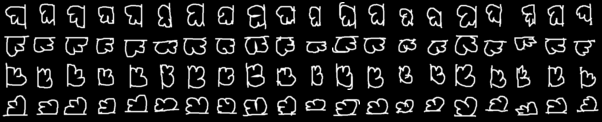

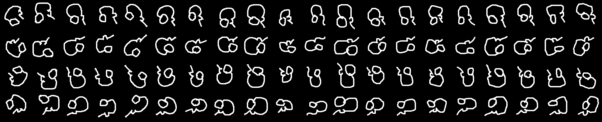

In [37]:
n_r = omniglot.n_rotations
for i in [967, 1003]:
    rots = torch.utils.data.ConcatDataset([
        omniglot.class_subset(omniglot.construct_class_id(i, r)) for r in range(n_r)
    ])
    X, y = read(rots)
    assert (omniglot.decompose_class_id(y)[0] == i).all()
    display(pil_grid(X, nrow=omniglot.n_per_class))

In [38]:
# Could turn this into a DataLoader's batch_sampler...  # SOLUTION
def load_episode(n_shots=5, n_classes=60, total_batch_size=600):
    per_class = total_batch_size // n_classes
    n_extra = omniglot.n_per_class - per_class
    assert n_extra >= 0
    assert total_batch_size % n_classes == 0
    assert n_shots < per_class
    
    base_class_ids = np.random.choice(training_base_classes, size=n_classes, replace=False)
    rotation_ids = np.random.randint(omniglot.n_rotations, size=n_classes)
    class_ids = [
        omniglot.construct_class_id(b, r) for b, r in zip(base_class_ids, rotation_ids)
    ]
    n_shots = np.random.choice([1, 5])
    n_query = per_class - n_shots

    parts = [
        torch.utils.data.random_split(
            omniglot.class_subset(class_id),
            [int(n) for n in [n_shots, n_query, n_extra]]
            # these are np.int64s, need to make ints...sigh
        )[:2]
        for class_id in class_ids
    ]
    train_ds, query_ds = [torch.utils.data.ConcatDataset(ps) for ps in zip(*parts)]

    train_X, train_y = read(train_ds)
    query_X, query_y = read(query_ds)
    
    return train_X, train_y, query_X, query_y, np.asarray(class_ids)

In [39]:
def convert_to_onehot(y, *other_ys):
    # We want one-hot matrices, but only for the labels we actually have.
    onehotter = sklearn.preprocessing.OneHotEncoder(
        categories='auto', dtype=np.float32, sparse=False)
    y = torch.as_tensor(onehotter.fit_transform(y[:, None]))
    other_ys = [torch.as_tensor(onehotter.transform(oth[:, None]), device=device)
                for oth in other_ys]
    
    def convert_back(labels):
        "Converts integers in the onehot output space to integers in onehot input space."
        return torch.as_tensor(onehotter.categories_[0], device=labels.device)[labels]
    
    return [y] + other_ys, convert_back

Set up the featurizing kernel:

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [41]:
training_base_classes, testing_base_classes = model_selection.train_test_split(
    np.arange(omniglot.n_base_classes), test_size=.1)

In [42]:
featurizer = support.R2D2Featurizer().to(device)

def composite_kernel(*parts):
    return LinearKernel(*[featurizer(p) for p in parts])

**Exercise:** implement the fitting and training loop, using the `load_episode` helper above. You might find the `convert_to_onehot` function useful as well, and the `convert_back` function it returns could be helpful to compute accuracies.

Hint: If you're not super experienced in PyTorch, the training loop for optimizng `sigma`/`lambda` above might be a useful reference. When constructing the optimizer, `list(featurizer.parameters())` gives you a list of all the parameters inside `featurizer`. You might also want to try `torch.optim.Adam` instead of `SGD` (or not).

If you get errors about `cuda.FloatTensor` versus regular `FloatTensor`s, you might have to add a `device` argument somewhere, e.g. to the `torch.eye` inside your `KernelRidgeRegression.fit`.

In [43]:
# SOLUTION
log_lam = torch.tensor(0.1, requires_grad=True, device=device)
opt = torch.optim.Adam([log_lam] + list(featurizer.parameters()), lr=1e-3)

In [44]:
# SOLUTION
with tqdm(range(1)) as bar:  # obviously you should run for more than one step :)
    for episode_i in bar:
        # load an episode
        train_X, train_y, query_X, query_y, class_ids = load_episode(
            n_shots=np.random.choice([1, 5]),
            total_batch_size=600,
            n_classes=60,
        )
        train_X = train_X.to(device)
        query_X = query_X.to(device)
        (train_y_onehot, query_y_onehot), convert_back = convert_to_onehot(train_y, query_y)
        train_y_onehot = train_y_onehot.to(device)
        query_y_onehot = query_y_onehot.to(device)

        opt.zero_grad()
        K = composite_kernel(train_X, query_X)
        krr = KernelRidgeRegression(reg_wt=torch.exp(log_lam))
        krr.fit(K.XX, train_y_onehot)
        loss, preds = krr.mse(K.XY, query_y_onehot, return_preds=True)

        loss.backward()
        opt.step()
        
        # compute accuracy
        preds_cls = convert_back(preds.argmax(1))
        acc = (preds_cls == query_y).sum().float() / query_y.shape[0]
        
        bar.set_postfix(loss=loss.item(), lam=torch.exp(log_lam).item(), acc=acc.item())

  0%|          | 0/1 [00:00<?, ?it/s]

**Exercise:** Play around with different kernels, including different featurizers. The source for `R2D2Featurizer` is in [`support/r2d2_featurizer.py`](support/r2d2_featurizer.py) if you want to build off that.

**If you have a decent GPU and some time:** Try a more complicated dataset; miniImageNet or CIFAR-FS. I didn't set these up for you, so this will take more effort.

**More complicated exercise:** A more effective way to do meta-learning for classification – that still uses kernels! – is [MetaOptNet](https://arxiv.org/abs/1904.03758). In that case, they use SVM classifiers, where the solver is not easy to differentiate through – but you can still find the derivative, because it's a convex problem, and you can differentiate the KKT conditions. (Their code, in PyTorch, is at [`kjunelee/MetaOptNet`](https://github.com/kjunelee/MetaOptNet).) This approach was later made *much* simpler to implement with the [`cvxpylayers`](https://github.com/cvxgrp/cvxpylayers) library. Try implementing a MetaOptNet-style meta-learner, using `cvxpylayers` or not, and playing around with it.